In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import squarify

import sys
import json
from copy import deepcopy

sys.path.append("..")
sys.path.append("../..")

from cge_modeling import Variable, Parameter, Equation, CGEModel
from cge_modeling.pytensorf.compile import (
    compile_cge_model_to_pytensor,
    euler_approximation_from_CGEModel,
    pytensor_objects_from_CGEModel,
)

In [2]:
from itertools import chain, compress
from cge_modeling.base.utilities import variable_dict_to_flat_array
from cge_modeling.production_functions import CES, dixit_stiglitz

In [3]:
sectors = ["Ag", "Ind", "Serv"]
eprod = ["coal", "nuc"]
n_sectors = len(sectors)
n_eprod = len(eprod)
coords = {"i": sectors, "j": sectors, "k": eprod, "g": eprod, "egrid": 1}

In [4]:
variable_info = [
    # Firm variables (7)
    Variable(name="Y", dims="i", description="Final output in the <dim:i> sector"),
    Variable(name="Y_E", dims="k", description="Final output in the <dim:k> energy sector"),
    Variable(name="VA", dims="i", description="Value-added component of <dim:i> sector production"),
    Variable(name="VC", dims="i", description="Value-chain component of <dim:i> sector production"),
    Variable(name="VC_E", dims="k", description="Value-chain component of <dim:k> energy producer"),
    Variable(
        name="X",
        dims=("i", "j"),
        description="Demand for <dim:i> sector goods by the <dim:j> sector as value-chain inputs",
    ),
    Variable(
        name="X_E",
        dims=("i", "k"),
        description="Demand for <dim:k> sector goods by the <dim:g> sector as value-chain inputs",
    ),
    # Captial Labour bundle
    Variable(
        name="L_S_d",
        dims="i",
        extend_subscript=True,
        description="Labor demand in the <dim:i> sector",
    ),
    Variable(
        name="L_E_d",
        dims="k",
        extend_subscript=True,
        description="Labor demand in the <dim:k> e-sector",
    ),
    Variable(
        name="K_S_d",
        dims="i",
        extend_subscript=True,
        description="Capital demand in the <dim:i> sector",
    ),
    Variable(
        name="K_E_d",
        dims="k",
        extend_subscript=True,
        description="Capital demand in the <dim:k> e-sector",
    ),
    Variable(
        name="KE_S_d",
        dims="i",
        extend_subscript=True,
        description="Labor Capital demand in the <dim:i> sector",
    ),
    Variable(
        name="KL_E_d",
        dims="k",
        extend_subscript=True,
        description="Capital energy bundle Capital demand in the <dim:k> e-sector",
    ),
    # Raw energy producer
    Variable(
        name="W_s",
        dims="k",
        extend_subscript=True,
        description="Raw energy demand of <dim:k> sector",
    ),
    Variable(
        name="R_d",
        dims="k",
        extend_subscript=True,
        description="Ressource demand of <dim:k> sector",
    ),
    Variable(
        name="E_d",
        dims="i",
        extend_subscript=True,
        description="Energy demand in the <dim:i> sector",
    ),
    Variable(
        name="E_s",
        description="Energy supply from energy bundler",
    ),
    # Investment
    Variable(
        name="I_d",
        dims="i",
        extend_subscript=True,
        description="Investment capital demanded by the <dim:i> sector",
    ),
    # Prices (7)
    Variable(name="P", dims="i", description="Final good price in the <dim:i> sector, after taxes"),
    Variable(
        name="P_Y",
        dims="i",
        extend_subscript=True,
        description="Final good price in the <dim:i> sector, before taxes",
    ),
    Variable(
        name="P_Y_E",
        dims="k",
        extend_subscript=True,
        description="Final good price in the <dim:k> energy sector, before taxes",
    ),
    Variable(
        name="P_VA",
        dims="i",
        extend_subscript=True,
        description="Price of the value-add component in the <dim:i> sector",
    ),
    Variable(
        name="P_VC",
        dims="i",
        extend_subscript=True,
        description="Price of the value-chain component in the <dim:i> sector",
    ),
    Variable(
        name="P_VC_E",
        dims="k",
        extend_subscript=True,
        description="Price of the value-chain component in the <dim:k> sector",
    ),
    Variable(
        name="P_KE_S",
        dims="i",
        extend_subscript=True,
        description="Capital labour bundle price in the <dim:i> sector",
    ),
    Variable(
        name="P_KL_E",
        dims="k",
        extend_subscript=True,
        description="Capital labour bundle price in the <dim:k> sector",
    ),
    Variable(
        name="P_E",
        extend_subscript=True,
        description="Electricity price",
    ),
    Variable(
        name="P_W",
        dims="k",
        extend_subscript=True,
        description="Raw energy price",
    ),
    Variable(
        name="P_R",
        dims="k",
        extend_subscript=True,
        description="Ressource energy price",
    ),
    Variable(name="r", description="Rental rate of capital"),
    Variable(name="w", description="Wage level"),
    Variable(
        name="r_star_S",
        latex_name="r^\\star_S",
        dims=("i",),
        description="<dim:i> after-tax rental rate",
        positive=True,
    ),
    Variable(
        name="r_star_E",
        latex_name="r^\\star_E",
        dims=("k",),
        description="<dim:k> after-tax rental rate",
        positive=True,
    ),
    Variable(
        name="w_star_S",
        dims=("i",),
        latex_name="w^\\star_S",
        description="<dim: i> after-tax wage level",
        positive=True,
    ),
    Variable(
        name="w_star_E",
        dims=("k",),
        latex_name="w^\\star_E",
        description="<dim: k> after-tax wage level",
        positive=True,
    ),
    # Household Variables
    Variable(name="U", description="Household utility"),
    Variable(name="C", dims="i", description="Household consumption of <dim:i> goods"),
    Variable(
        name="I_s", extend_subscript=True, description="Investment capital supplied by households"
    ),
    Variable(name="S", description="Household savings"),
    Variable(name="income", latex_name="Omega", description="Household income, before taxes"),
    Variable(
        name="net_income", latex_name="\hat{\Omega}", description="Household income, after taxes"
    ),
    # Government variables
    Variable(name="G", description="Government budget"),
    Variable(
        name="C_G",
        dims="i",
        extend_subscript=True,
        description="Government consumption of <dim:i> goods",
    ),
    Variable(
        name="S_G",
        extend_subscript=True,
        positive=None,
        description="Investment capital supplied by government",
    ),
    # Misc
    Variable(name="resid", latex_name=r"varepsilon", description="Walrasian residual"),
]

param_info = [
    # Production Parameters
    Parameter(
        "alpha_VA",
        dims="i",
        description="Share of capital in production of the <dim:i> sector value-add bundle",
    ),
    Parameter(
        "alpha_KE_S",
        dims="i",
        description="Share of capital in production of the <dim:i> producer capital labour bundle",
    ),
    Parameter(
        "alpha_KL_E",
        dims="k",
        description="Share of capital in production of the <dim:k> producer capital labour bundle",
    ),
    Parameter(
        "alpha_W",
        dims="k",
        description="Share of capital in production of the <dim:k> producer capital labour bundle",
    ),
    Parameter(
        "alpha_k",
        dims="i",
        extend_subscript=True,
        description="Share of capital investment demanded by the <dim:i> sector",
    ),
    Parameter(
        "alpha_Es",
        dims="k",
        extend_subscript=True,
        description="Share of raw energy type <dim:k> in total energy mix",
    ),
    # Technology parameters
    Parameter("A_VA", dims="i", description="Total factor productivity of the <dim:i> sector"),
    Parameter("A_W", dims="k", description="Total factor productivity of the <dim:k> sector"),
    Parameter(
        "A_KE_S", dims="i", description="Captial Labour factor productivity of <dim:i> producer"
    ),
    Parameter(
        "A_KL_E", dims="k", description="Captial Labour factor productivity of <dim:k> producer"
    ),
    Parameter("A_Es", description="Total factor productivity of Energy production"),
    # Leontief shares
    Parameter(
        "psi_VA",
        extend_subscript=True,
        dims="i",
        description="Share of value-add bundle in <dim:i> sector final good production",
    ),
    Parameter(
        "psi_VC",
        extend_subscript=True,
        dims="i",
        description="Share of value chain bundle in <dim:i> sector final good production",
    ),
    Parameter(
        "psi_X",
        extend_subscript=True,
        dims=("i", "j"),
        description="Share of <dim:j> sector final goods in the <dim:i> value chain bundle",
    ),
    Parameter(
        "psi_VC_E",
        extend_subscript=True,
        dims="k",
        description="Share of value chain bundle in <dim:k> sector final good production",
    ),
    Parameter(
        "psi_X_E",
        extend_subscript=True,
        dims=("i", "k"),
        description="Share of <dim:g> sector final goods in the <dim:k> value chain bundle",
    ),
    Parameter(
        "psi_W",
        extend_subscript=True,
        dims="k",
        description="Share of energy in <dim:k> energy sector final energy production",
    ),
    # CES elasticities
    Parameter(
        name="epsilon_VA",
        extend_subscript=True,
        dims="i",
        description="Elasticity of subsitution between input factors in <dim:i> sector VA bundle",
    ),
    Parameter(
        name="epsilon_W",
        extend_subscript=True,
        dims="k",
        description="Elasticity of subsitution between input factors in <dim:k> sector W",
    ),
    Parameter(
        name="epsilon_KE_S",
        extend_subscript=True,
        dims="i",
        description="Elasticity of subsitution between input factors in <dim:i> producer KL bundle",
    ),
    Parameter(
        name="epsilon_KL_E",
        extend_subscript=True,
        dims="k",
        description="Elasticity of subsitution between input factors in <dim:k> producer KL bundle",
    ),
    Parameter(
        name="epsilon_Es",
        extend_subscript=True,
        description="Elasticity of subsitution between raw energy sources",
    ),
    # Tax parameters
    Parameter(name="tau_income", latex_name="\\tau_Y", description="Income tax rate"),
    Parameter(
        name="tau_sales",
        dims=("i",),
        extend_subscript=True,
        latex_name="\\tau_P",
        description="Sales tax rate in sector <dim:i>",
    ),
    Parameter(
        name="tau_capital_S",
        dims=("i",),
        extend_subscript=True,
        latex_name="\\tau_r_S",
        description="Capital income tax in sector <dim:i>",
    ),
    Parameter(
        name="tau_capital_E",
        dims=("k",),
        extend_subscript=True,
        latex_name="\\tau_r_E",
        description="Capital income tax in sector <dim:k>",
    ),
    Parameter(
        name="tau_wage_S",
        dims=("i",),
        extend_subscript=True,
        latex_name="\\tau_w_S",
        description="Payroll tax in sector <dim:i>",
    ),
    Parameter(
        name="tau_wage_E",
        dims=("k",),
        extend_subscript=True,
        latex_name="\\tau_w_E",
        description="Payroll tax in sector <dim:k>",
    ),
    # Household parameters
    Parameter(
        "alpha_C",
        dims="i",
        description="Household elasticity of consumption utility for <dim:i> sector goods",
    ),
    Parameter("mpc", latex_name="phi", description="Household marginal propensity to consume"),
    # Government parameters
    Parameter(
        "alpha_G",
        dims="i",
        description="Share of <dim:i> sector final goods in governmnet consumption",
    ),
    # Exogenous values
    Parameter("L_s", description="Exogenous labor supply"),
    Parameter("R_s", dims="k", description="Exogenous raw energy endowment"),
    Parameter("K_s", description="Exogenous capital supply"),
    Parameter("P_num", latex_name=r"\\bar{P}_{num}", description="Numeraire price"),
    Parameter(
        "S_G_bar",
        latex_name=r"\\bar{S}_G",
        description="Exogenous level of governmnet savings",
        positive=None,
    ),
]

va_eqs = CES(
    factors=["KE_S_d", "L_S_d"],
    factor_prices=["P_KE_S", "w_star_S"],
    output="VA",
    output_price="P_VA",
    TFP="A_VA",
    factor_shares="alpha_VA",
    epsilon="epsilon_VA",
)

ke_s_eqs = CES(
    factors=["K_S_d", "E_d"],
    factor_prices=["r_star_S", "P_E"],
    output="KE_S_d",
    output_price="P_KE_S",
    TFP="A_KE_S",
    factor_shares="alpha_KE_S",
    epsilon="epsilon_KE_S",
)
kl_e_eqs = CES(
    factors=["K_E_d", "L_E_d"],
    factor_prices=["r_star_E", "w_star_E"],
    output="KL_E_d",
    output_price="P_KL_E",
    TFP="A_KL_E",
    factor_shares="alpha_KL_E",
    epsilon="epsilon_KL_E",
)
w_eqs = CES(
    factors=["KL_E_d", "R_d"],
    factor_prices=["P_KL_E", "P_R"],
    output="W_s",
    output_price="P_W",
    TFP="A_W",
    factor_shares="alpha_W",
    epsilon="epsilon_W",
)

energy_bundler_eqs = dixit_stiglitz(
    factors="Y_E",
    factor_prices="P_Y_E",
    output="E_s",
    output_price="P_E",
    TFP="A_Es",
    factor_shares="alpha_Es",
    epsilon="epsilon_Es",
    dims="k",
    coords=coords,
)

equations = [
    # Sector Final Goods
    Equation("Final good production of sector <dim:i>", "P_Y * Y = P_VC * VC + P_VA * VA"),
    Equation("Sector <dim:i> demand for intermediate goods bundle", "VC = psi_VC * Y"),
    Equation("Sector <dim:i> demand for value added", "VA = psi_VA * Y"),
    # Value chain bundle
    Equation(
        "Sector <dim:i> production of intermediate goods bundle",
        "VC * P_VC = Sum(P_Y.subs({i:j}) * X.subs([(i,z), (j,i), (z,j)]),"
        + f"(j, 0, {n_sectors - 1}))",
    ),
    Equation(
        "Sector <dim:i> demand for sector <dim:j> intermediate input",
        "X = psi_X * VC.subs({i:j})",
    ),
    # Sector Final Goods
    Equation(
        "Final good production of energy producer <dim:k>",
        "P_Y_E * Y_E = P_VC_E * VC_E + P_W * W_s",
    ),
    Equation("Sector <dim:k> demand for intermediate goods bundle", "VC_E = psi_VC_E * Y_E"),
    Equation("Sector <dim:k> demand for value added", "W_s = psi_W * Y_E"),
    # Value chain bundle
    Equation(
        "Energy producer <dim:k> production of intermediate goods bundle",
        "VC_E * P_VC_E = Sum(P_Y_E * X_E, " + f"(i, 0, {n_sectors - 1}))",
    ),
    Equation(
        "Sector <dim:k> demand for sector <dim:i> intermediate input",
        "X_E = psi_X_E * VC_E.subs({i:k})",
    ),
    # Value add bundle
    Equation("Sector <dim:i> production of value add", va_eqs[0]),
    Equation("Sector <dim:i> demand for capital energy bundle", va_eqs[1]),
    Equation("Sector <dim:i> demand for labour", va_eqs[2]),
    # Capital Labour aggregation
    Equation("Producer <dim:i> production of capital and energy", ke_s_eqs[0]),
    Equation("Producer <dim:i> demand for captial", ke_s_eqs[1]),
    Equation("Producer <dim:i> demand for energy", ke_s_eqs[2]),
    # Energy types
    Equation("Energy producer <dim:k> production", w_eqs[0]),
    Equation("Sector <dim:k> demand for capital labour bundle", w_eqs[1]),
    Equation("Sector <dim:k> demand for raw energy", w_eqs[2]),
    # Capital Labour aggregation
    Equation("Producer <dim:k> production of capital and labour", kl_e_eqs[0]),
    Equation("Producer <dim:k> demand for captial", kl_e_eqs[1]),
    Equation("Producer <dim:k> demand for labour", kl_e_eqs[2]),
    # Electricity aggregation
    Equation("Electricity production", energy_bundler_eqs[0]),
    Equation("Electrictiy production demand for raw energy <dim:k>", energy_bundler_eqs[1]),
    # Sector invest
    Equation("<dim:i> sector demand for installed capital", "P_Y * I_d = alpha_k * I_s"),
    # Government block
    Equation(name="Price level of sector <dim:i>", equation="P = (1 + tau_sales) * P_Y"),
    Equation(
        name="Net rental rate in sector <dim:i>", equation="r_star_S = (1 + tau_capital_S) * r"
    ),
    Equation(name="Net wage level in sector <dim:i>", equation="w_star_S = (1 + tau_wage_S) * w"),
    Equation(
        name="Net rental rate in sector <dim:k>", equation="r_star_E = (1 + tau_capital_E) * r"
    ),
    Equation(name="Net wage level in sector <dim:k>", equation="w_star_E = (1 + tau_wage_E) * w"),
    Equation(
        "Government budget constraint",
        "G + S_G = tau_income * income"
        + "+ Sum(tau_sales * P_Y * C, "
        + f"(i, 0, {n_sectors-1}))"
        + "+ Sum(tau_capital_S * r * K_S_d + tau_wage_S * w * L_S_d, "
        + f" (i, 0, {n_sectors - 1}))"
        + "+ Sum(tau_capital_E * r * K_E_d + tau_wage_E * w * L_E_d, "
        + f"(k, 0, {n_eprod - 1}))",
    ),
    Equation("Government consumption of <dim:i> sector goods", "C_G = alpha_G * G"),
    Equation("Exogenous government savings", "S_G = S_G_bar"),
    # Household block
    Equation(
        "Household pre-tax income",
        "income = w * L_s + r * K_s" + "+ Sum(R_s * P_R, " + f"(k, 0, {n_eprod-1}))",
    ),
    Equation("Household after-tax income", "net_income = (1 - tau_income) * income"),
    Equation("Household utility", "U = Product(C**alpha_C, " + f"(i, 0, {n_sectors-1}))"),
    Equation("Household demand for good <dim:i>", "C * P = alpha_C * mpc * net_income"),
    Equation("Household savings", "S = (1 - mpc) * net_income"),
    # Economic equilibrium
    Equation("Investment market clearing", "I_s = S + S_G + resid"),
    Equation(
        "Labour market clearing",
        "L_s = Sum(L_S_d, "
        + f"(i, 0, {n_sectors - 1}))"
        + " + Sum(L_E_d, "
        + f"(k, 0, {n_eprod-1}))",
    ),
    Equation(
        "Capital market clearing",
        "K_s = Sum(K_S_d, "
        + f"(i, 0, {n_sectors - 1}))"
        + " + Sum(K_E_d, "
        + f"(k, 0, {n_eprod-1}))",
    ),
    Equation(
        "Energy market clearing",
        "E_s = Sum(E_d, " + f" (i, 0, {n_sectors - 1}))",
    ),
    Equation("Ressource energy market clearing <dim:k>", "R_s = R_d"),
    Equation(
        "Sector <dim:i> goods market clearing",
        f"Y = C + C_G + I_d + Sum(X, "
        + f"(j, 0, {n_sectors - 1}))"
        + "+ Sum(X_E, "
        + f"(k, 0, {n_eprod-1}))",
    ),
    Equation("Numeraire", "P.subs({i:'Ag'}) = P_num"),
]

In [5]:
ke_s_eqs

('KE_S_d = A_KE_S * ((alpha_KE_S) * K_S_d ** ((epsilon_KE_S - 1) / epsilon_KE_S) + (1 - alpha_KE_S) * E_d ** ((epsilon_KE_S - 1) / epsilon_KE_S)) ** (epsilon_KE_S / (epsilon_KE_S - 1))',
 'K_S_d = KE_S_d / A_KE_S * ((alpha_KE_S) * P_KE_S * A_KE_S / r_star_S) ** epsilon_KE_S',
 'E_d = KE_S_d / A_KE_S * ((1 - alpha_KE_S) * P_KE_S * A_KE_S / P_E) ** epsilon_KE_S')

In [200]:
mod = CGEModel(
    variables=variable_info,
    parameters=param_info,
    equations=equations,
    coords=coords,
    parse_equations_to_sympy=True,
    backend="numba",
    # mode="JAX",
    compile=True,
)

In [201]:
mod.n_variables

106

In [202]:
len(mod.unpacked_equation_names)

106

In [203]:
# backward calibration SAM

In [204]:
df = pd.read_csv("data/11_sam_tax.csv", index_col=[0, 1], header=[0, 1]).map(float).fillna(0)
# assert np.allclose(df.sum(axis=0), df.sum(axis=1))

In [205]:
sectors_pretty_name = list(df["Production"].columns[:n_sectors])
eprod_pretty_name = list(df["Production"].columns[-len(eprod) :])

In [206]:
df.loc[("Use Tax", "Labor"), ("Production", eprod_pretty_name)]

Production  Coal       200.0
            Nuclear    150.0
Name: (Use Tax, Labor), dtype: float64

In [207]:
initial_data = {
    "income_tax_revenue": df.loc[("Income Tax", "Household"), ("Institution", "Household")],
    "sales_tax_revenue": df.loc["Sales Tax", ("Institution", "Household")]
    .loc[sectors_pretty_name]
    .values,
    #     "sales_tax_revenue_E": df.loc["Sales Tax", ("Institution", "Household")].loc[eprod_pretty_name].values,
    "capital_tax_revenue_S": df.loc[
        ("Use Tax", "Capital"), ("Production", sectors_pretty_name)
    ].values,
    "capital_tax_revenue_E": df.loc[
        ("Use Tax", "Capital"), ("Production", eprod_pretty_name)
    ].values,
    "wage_tax_revenue_S": df.loc[("Use Tax", "Labor"), ("Production", sectors_pretty_name)].values,
    "wage_tax_revenue_E": df.loc[("Use Tax", "Labor"), ("Production", eprod_pretty_name)].values,
    "S": df.loc[("Other", "Capital Accumulation"), ("Institution", "Household")],
    "S_G": df.loc[("Other", "Capital Accumulation"), ("Institution", "Govt")],
    "L_S_d": df.loc[("Factor", "Labor"), ("Activities", sectors_pretty_name)].values,
    "K_S_d": df.loc[("Factor", "Capital"), ("Activities", sectors_pretty_name)].values,
    "L_E_d": df.loc[("Factor", "Labor"), ("Activities", eprod_pretty_name)].values,
    "K_E_d": df.loc[("Factor", "Capital"), ("Activities", eprod_pretty_name)].values,
    "E_d": df.loc[("Factor", "Electricity"), ("Activities", sectors_pretty_name)].values,
    "R_d": df.loc[("Institution", "Household"), ("Factor", eprod_pretty_name)].values,
    "I_d": df.loc[("Production", sectors_pretty_name), ("Other", "Capital Accumulation")].values,
    "C": df.loc[("Production", sectors_pretty_name), ("Institution", "Household")].values,
    "C_G": df.loc[("Production", sectors_pretty_name), ("Institution", "Govt")].values,
    "Y": df.loc[("Production")].loc[sectors_pretty_name].sum(axis=1).values,
    "Y_E": df.loc["Production"].loc[eprod_pretty_name, ("Factor", "Electricity")].values,
    "X": df.loc["Production", "Activities"].loc[sectors_pretty_name, sectors_pretty_name].values,
    "X_E": df.loc["Production", ("Activities", eprod_pretty_name)].loc[sectors_pretty_name].values,
}

econometric_estimates = {
    "epsilon_VA": np.ones(n_sectors) * 10.0,
    "epsilon_KE_S": np.ones(n_sectors) * 10.0,
    "epsilon_KL_E": np.ones(n_eprod) * 10.0,
    "epsilon_W": np.ones(n_eprod) * 5.0,
    "epsilon_Es": 3.0,
}

In [208]:
initial_data

{'income_tax_revenue': 600.0,
 'sales_tax_revenue': array([500., 800., 400.]),
 'capital_tax_revenue_S': array([200., 400., 100.]),
 'capital_tax_revenue_E': array([100., 120.]),
 'wage_tax_revenue_S': array([100., 200., 100.]),
 'wage_tax_revenue_E': array([200., 150.]),
 'S': 950.0,
 'S_G': 100.0,
 'L_S_d': array([1400., 2100., 4100.]),
 'K_S_d': array([ 400., 2200.,  700.]),
 'L_E_d': array([150.,  50.]),
 'K_E_d': array([50., 80.]),
 'E_d': array([1400., 1800., 1300.]),
 'R_d': array([ 850., 1200.]),
 'I_d': array([100., 800., 150.]),
 'C': array([2150., 3030., 4650.]),
 'C_G': array([1000., 1970., 1100.]),
 'Y': array([ 5800., 12250., 10700.]),
 'Y_E': array([2000., 2500.]),
 'X': array([[ 230.,  800., 1100.],
        [ 600., 3040., 2000.],
        [1470., 1710., 1300.]]),
 'X_E': array([[ 20., 400.],
        [610., 200.],
        [ 20., 300.]])}

In [209]:
def get_CES_2goods_params(fac1, fac2, p1, p2, output, epsilon):
    _rho = (epsilon - 1) / epsilon
    alpha = p1 * fac1 ** (1 / epsilon) / ((p1 * fac1 ** (1 / epsilon) + p2 * fac2 ** (1 / epsilon)))
    A = output * (alpha * fac1**_rho + (1 - alpha) * fac2**_rho) ** (-1 / _rho)
    return A, alpha

In [210]:
def calibrate_model(
    income_tax_revenue,
    sales_tax_revenue,
    capital_tax_revenue_S,
    capital_tax_revenue_E,
    wage_tax_revenue_S,
    wage_tax_revenue_E,
    S,
    S_G,
    L_S_d,
    K_S_d,
    L_E_d,
    K_E_d,
    E_d,
    R_d,
    C,
    C_G,
    Y,
    Y_E,
    X,
    X_E,
    I_d,
    epsilon_VA,
    epsilon_KE_S,
    epsilon_KL_E,
    epsilon_W,
    epsilon_Es,
    variables,
    parameters,
):
    # taxes
    tau_sales = sales_tax_revenue / C
    tau_capital_S = capital_tax_revenue_S / K_S_d
    tau_capital_E = capital_tax_revenue_E / K_E_d
    tau_wage_S = wage_tax_revenue_S / L_S_d
    tau_wage_E = wage_tax_revenue_E / L_E_d

    # Normalize prices to 1
    w = 1.0
    r = 1.0
    P_E = 1.0

    P_VA = np.ones(n_sectors)
    P_VC = np.ones(n_sectors)
    P_Y = np.ones(n_sectors)

    P_VC_E = np.ones(n_eprod)
    P_Y_E = np.ones(n_eprod)

    P_KE_S = np.ones(n_sectors)
    P_KL_E = np.ones(n_eprod)

    P_W = np.ones(n_eprod)
    P_R = np.ones(n_eprod)

    P = P_Y * (1 + tau_sales)

    r_star_S = r * (1 + tau_capital_S)
    w_star_S = w * (1 + tau_wage_S)

    r_star_E = r * (1 + tau_capital_E)
    w_star_E = w * (1 + tau_wage_E)

    # Zero the residual
    resid = 0.0

    # Factor supplies
    L_s = L_S_d.sum() + L_E_d.sum()
    K_s = K_S_d.sum() + K_E_d.sum()
    E_s = E_d.sum()

    R_s = R_d

    # Numeraire
    P_num = P[0]

    # Firm calibration
    KE_S_d = (K_S_d * r_star_S + E_d * P_E) / P_KE_S
    KL_E_d = (K_E_d * r_star_E + L_E_d * w_star_E) / P_KL_E

    VA = (P_KE_S * KE_S_d + w_star_S * L_S_d) / P_VA
    W_s = (KL_E_d * P_KL_E + R_d * P_R) / P_W

    VC = (P_Y[:, None] * X).sum(axis=0) / P_VC

    # Final good sector Value Add
    A_VA, alpha_VA = get_CES_2goods_params(
        fac1=KE_S_d, fac2=L_S_d, p1=P_KE_S, p2=w_star_S, output=VA, epsilon=epsilon_VA
    )
    A_KE_S, alpha_KE_S = get_CES_2goods_params(
        fac1=K_S_d, fac2=E_d, p1=r_star_S, p2=P_E, output=KE_S_d, epsilon=epsilon_KE_S
    )

    # Energy sector production function
    A_KL_E, alpha_KL_E = get_CES_2goods_params(
        fac1=K_E_d, fac2=L_E_d, p1=r_star_E, p2=w_star_E, output=KL_E_d, epsilon=epsilon_KL_E
    )
    A_W, alpha_W = get_CES_2goods_params(
        fac1=KL_E_d, fac2=R_d, p1=P_KL_E, p2=P_R, output=W_s, epsilon=epsilon_W
    )

    VC_E = (P_Y_E * Y_E - P_W * W_s) / P_VC_E

    # Energy mix aggregator
    _rho = (epsilon_Es - 1) / epsilon_Es
    alpha_Es = P_Y_E * Y_E ** (1 / epsilon_Es) / (P_Y_E * Y_E ** (1 / epsilon_Es)).sum()
    A_Es = E_s / (alpha_Es * Y_E ** ((epsilon_Es - 1) / epsilon_Es)).sum() ** (
        epsilon_Es / (epsilon_Es - 1)
    )

    psi_VA = VA / Y
    psi_VC = VC / Y
    psi_VC_E = VC_E / Y_E
    psi_X = X / VC[None]
    psi_X_E = X_E / VC_E[None]
    psi_W = W_s / Y_E

    income = w * L_s + r * K_s + (P_R * R_d).sum()
    tau_income = income_tax_revenue / income
    net_income = (1 - tau_income) * income

    mpc = 1 - S / net_income
    consumption_spend = mpc * net_income

    alpha_C = P * C / consumption_spend
    U = np.prod(C**alpha_C)

    # Exogenous government spending level
    S_G_bar = S_G

    G = (
        tau_income * income
        + (tau_sales * P_Y * C).sum()
        + (tau_capital_S * r * K_S_d + tau_wage_S * w * L_S_d).sum()
        + (tau_capital_E * r * K_E_d + tau_wage_E * w * L_E_d).sum()
        - S_G
    )
    alpha_G = C_G / G

    I_s = S + S_G
    alpha_k = (P_Y * I_d) / I_s

    d = {}
    for obj in variables + parameters:
        if obj.name != "_":
            d[obj.name] = locals()[obj.name]

    return d

In [211]:
calibrated_data = calibrate_model(
    **(initial_data | econometric_estimates), variables=mod.variables, parameters=mod.parameters
)

In [213]:
mod.check_for_equilibrium(calibrated_data)

Equilibrium found! Total squared error: 0.000000


# Simulation

In [214]:
from cge_modeling.base.utilities import flat_array_to_variable_dict, variable_dict_to_flat_array
from copy import deepcopy

tax_cut = deepcopy(calibrated_data)

# 50% income tax cut
tax_cut["tau_income"] *= 0.5
_, theta_tax_cut = variable_dict_to_flat_array(tax_cut, mod.variables, mod.parameters)

In [215]:
n_steps = 10
idata = mod._solve_with_euler_approximation(
    calibrated_data, theta_final=theta_tax_cut, n_steps=n_steps
)

  0%|                                                                                                         …

In [216]:
d = idata.isel(step=-1).to_dict()["variables"] | idata.isel(step=-1).to_dict()["parameters"]
var_inputs = np.r_[*[np.atleast_1d(d[x]).ravel() for x in mod.variable_names]]
param_inputs = np.r_[*[np.atleast_1d(d[x]).ravel() for x in mod.parameter_names]]
mod.f_resid(var_inputs, param_inputs)

array(5.30598871e-06)

In [221]:
idata = mod.simulate(calibrated_data, final_delta_pct={"L_s": 0.9})

  0%|                                                                                                         …

C:\Users\LukasGrahl\miniforge3\envs\mamba_env_CGE\Lib\site-packages\scipy\optimize\_root.py:210: RuntimeWarning: Method hybr does not accept callback.
  warn('Method %s does not accept callback.' % method,


C:\Users\LukasGrahl\Documents\GIT\cge_modeling\notebooks\..\cge_modeling\plotting.py:125: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


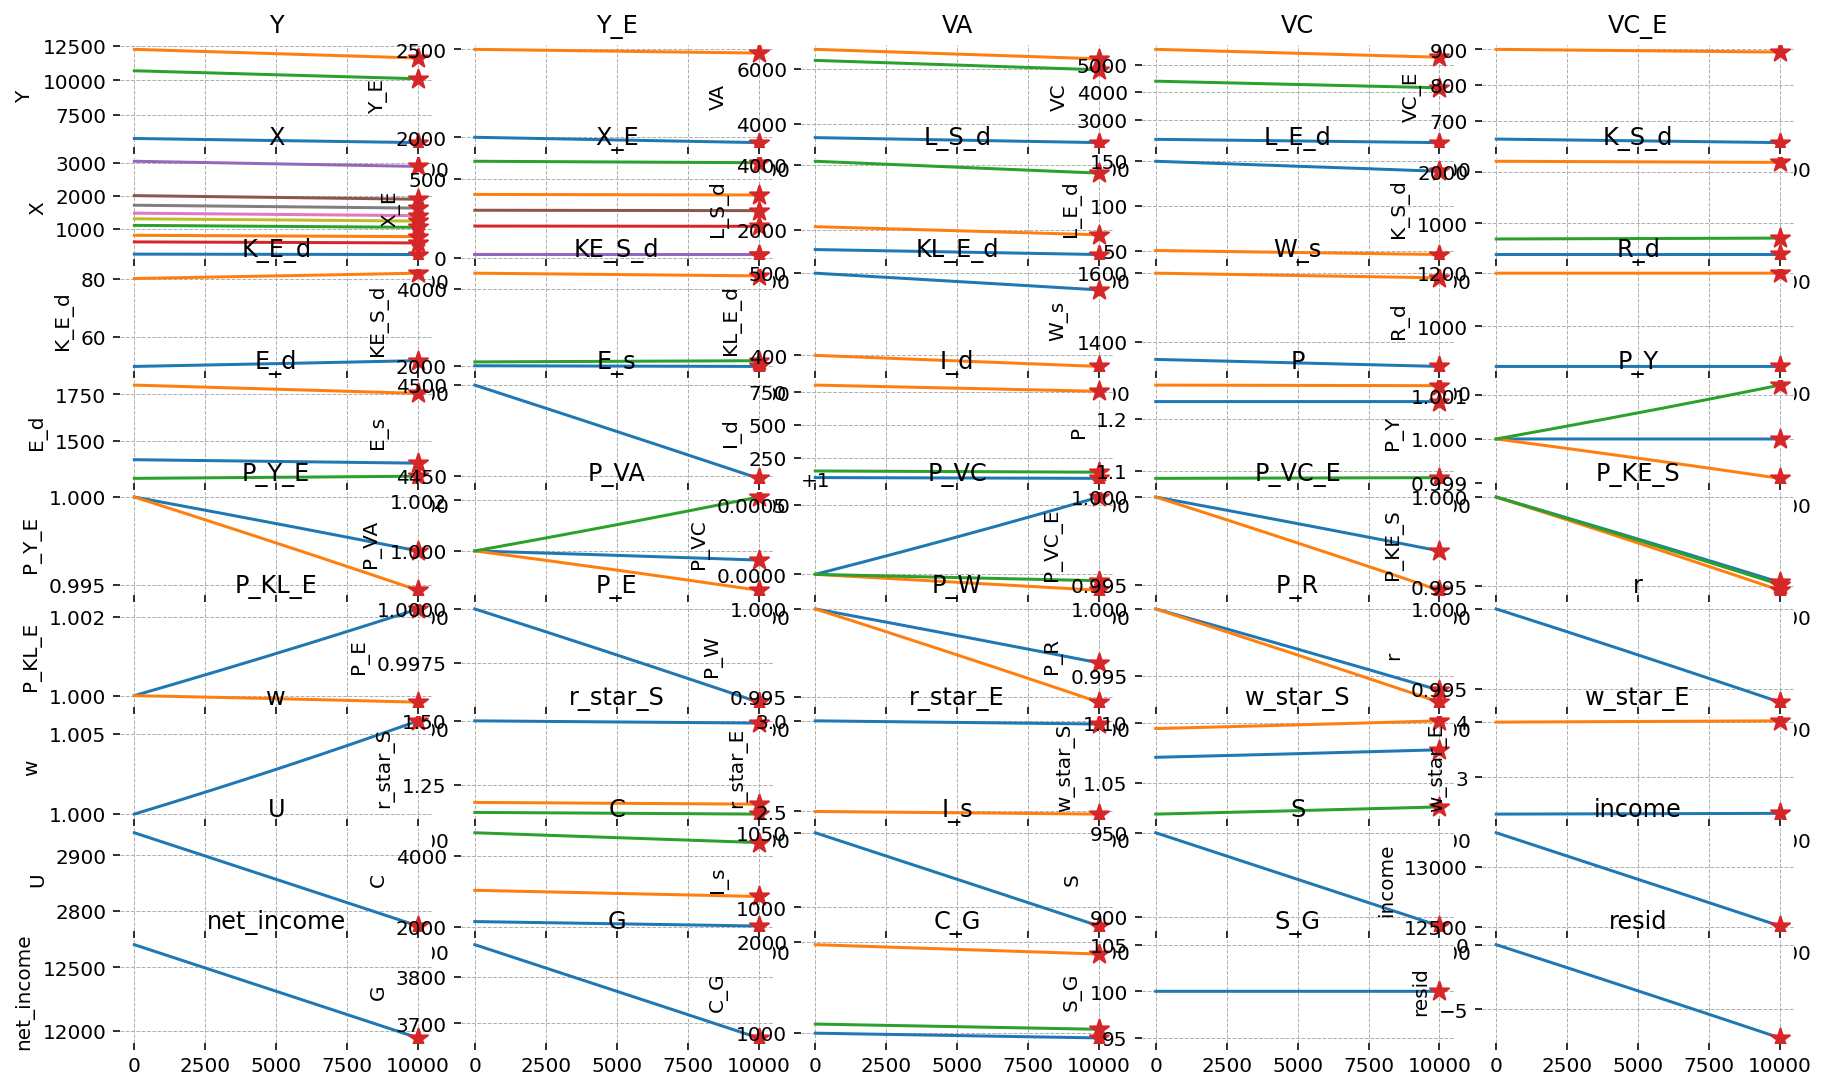

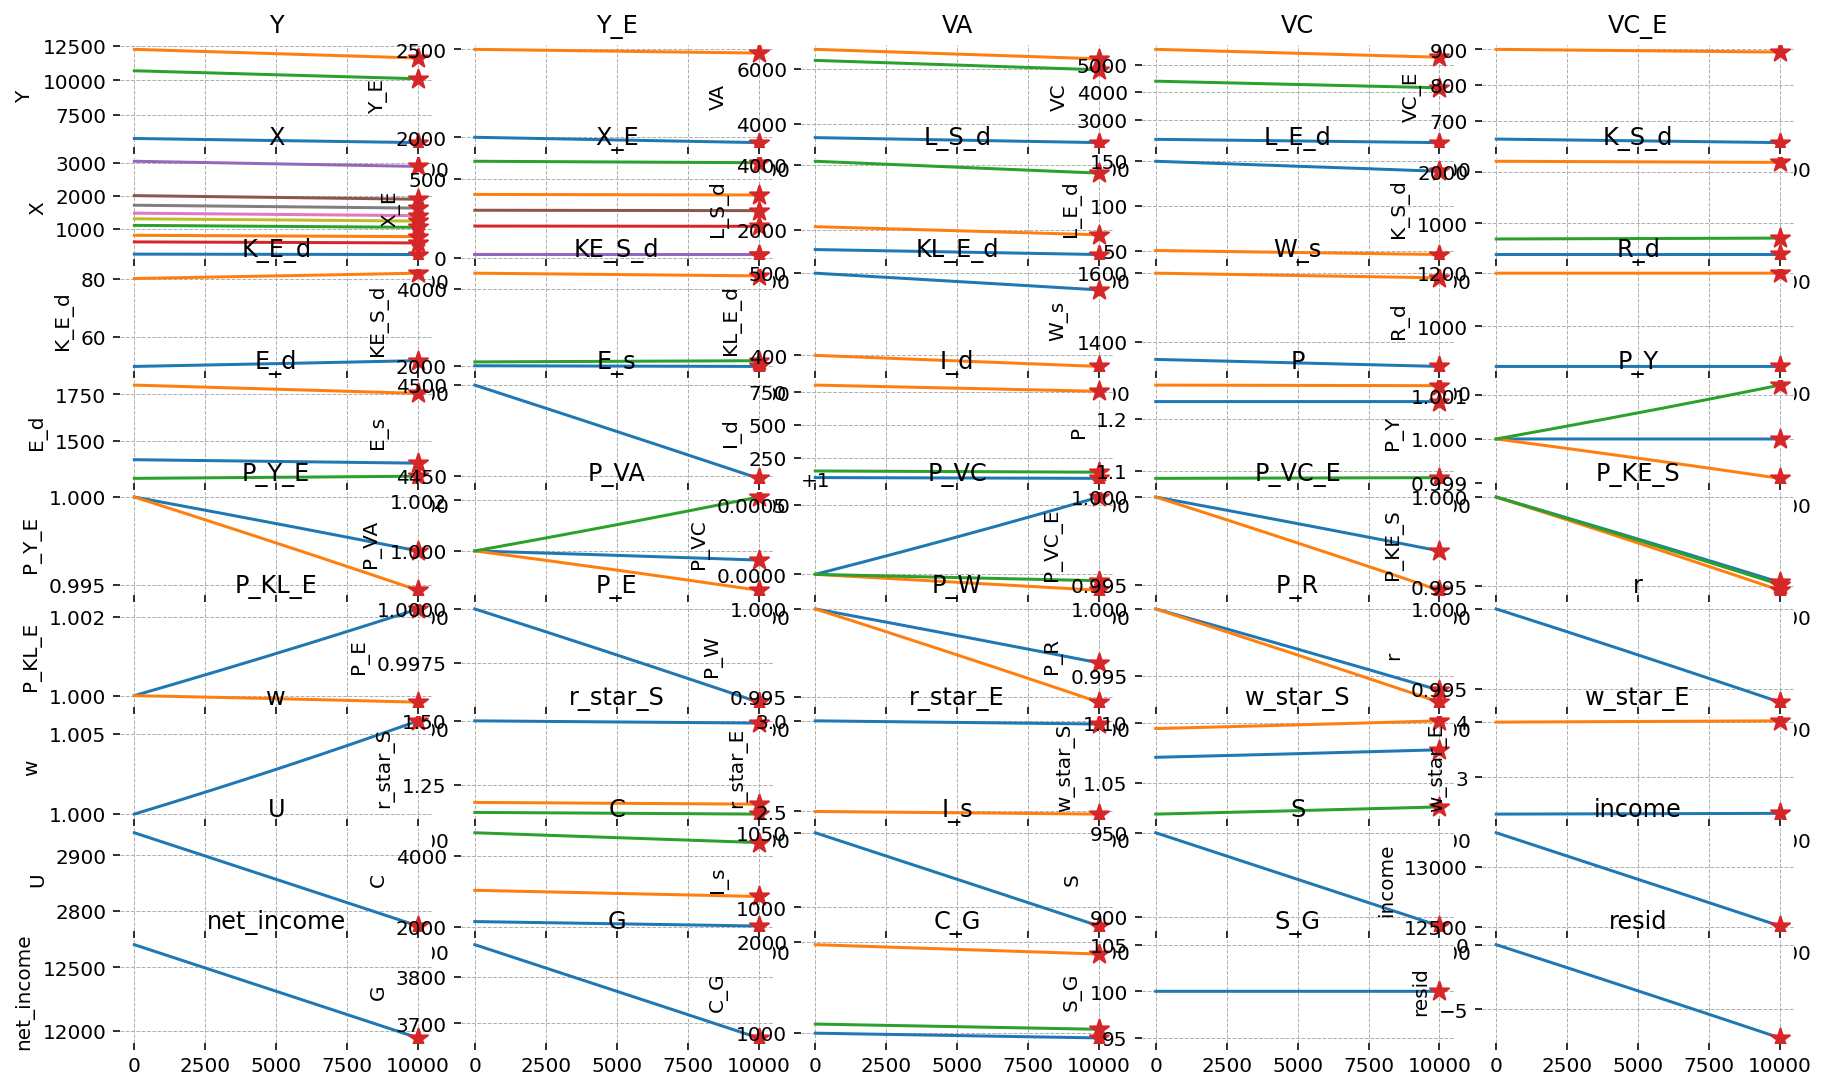

In [224]:
plot_lines(idata, mod)